In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import torch
torch.no_grad()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
MSSV=21521413

In [3]:
def initialize_population(num_individuals, num_variables):
    """
    Khởi tạo quần thể gồm num_individuals cá thể. Mỗi cá thể có num_parameters biến.

    Arguments:
    num_individuals -- Số lượng cá thể
    num_variables -- Số lượng biến

    Returns:
    pop -- Ma trận (num_individuals, num_variables ) chứa quần thể mới được khởi tạo ngẫu nhiên.
    """

    pop = torch.randint(0, 2, (num_individuals, num_variables), device=device)

    return pop


In [4]:
def onemax(ind):
    """
    Hàm đánh giá OneMax: Đếm số bit 1 trong chuỗi nhị phân (cá thể ind).

    Arguments:
    ind -- Cá thể cần được đánh giá.

    Returns:
    value -- Giá trị của cá thể ind.
    """

    return torch.sum(ind, dim=-1)


def leadingOnes(ind):
    first_gene_from_each_ind = ind[:,0]
    first_0_idx = torch.argmin(ind, dim=-1)
    return torch.where(first_0_idx==0, first_gene_from_each_ind*(ind.shape[1]), first_0_idx)

def concatenated_trap_K(ind, k=5):
    num_individuals, num_parameters = ind.shape

    ones = ind.reshape((num_individuals, -1, k)).sum(axis=-1)

    trap_values = torch.where(ones < k, k - 1 - ones, k)

    return trap_values.sum(dim=-1)

In [5]:
t = torch.tensor([
    [1,1,1,1,0],
    [1,1,1,1,0],
])
leadingOnes(t)

tensor([4, 4])

In [6]:
def crossover_1X(pop):
    num_individuals, num_parameters = pop.shape
    shuffle_indices = torch.randperm(num_individuals, device=device)
    pop = pop[shuffle_indices]

    num_pairs = num_individuals // 2

    pop1 = pop.reshape(-1)
    pop2 = pop.reshape((2, num_pairs, num_parameters)).flip(0).reshape((-1))

    probability = torch.zeros(num_pairs * num_parameters, device=device)
    crossover_indices = torch.randint(0, num_parameters, (num_pairs,), device=device) + torch.arange(0, num_pairs * num_parameters, num_parameters, device=device)


    for i in range(num_pairs):
      chunk_start = i * num_parameters
      chunk_end = (i + 1) * num_parameters
      crossover_index = crossover_indices[i]
      probability[crossover_index: chunk_end] = 1

    probability = (
      probability.unsqueeze(0)
      .expand((2, num_pairs * num_parameters))
      .reshape((-1))
    )

    offsprings = torch.where(probability == 0, pop1, pop2)

    return offsprings.reshape((num_individuals, num_parameters))

def crossover_UX(pop):
    num_individuals, num_parameters = pop.shape
    shuffle_indices = torch.randperm(num_individuals, device=device)
    pop = pop[shuffle_indices]

    num_pairs = num_individuals // 2

    pop1 = pop.reshape(-1)
    pop2 = pop.reshape((2, num_pairs, num_parameters)).flip(0).reshape((-1))
    probability = (
        torch.rand(num_pairs * num_parameters, device=device)
        .unsqueeze(0)
        .expand((2, num_pairs * num_parameters))
        .reshape((-1))
    )

    offsprings = torch.where(probability < 0.5, pop1, pop2)

    return offsprings.reshape((num_individuals, num_parameters))

In [7]:
def is_converge(tensor):
    first_value = tensor.flatten()[0]
    return torch.all(tensor == first_value)

In [8]:
def tournament_selection(pop, pop_fitness, selection_size, tournament_size=4):
    num_individuals, num_parameters = pop.shape

    distribution = torch.ones((selection_size, num_individuals), device=device)

    tournament_indices = distribution.multinomial(
        num_samples=tournament_size,
        replacement=False
    ).flatten()

    tournament_fitness = pop_fitness[tournament_indices]

    tournament_fitness = tournament_fitness.reshape((selection_size, tournament_size))

    winners_indices = torch.argmax(tournament_fitness, dim=1)

    winners_indices = winners_indices + torch.arange(selection_size, device=device) * tournament_size

    return tournament_indices[winners_indices]


In [9]:
def genetic_algorithm(objective, crossover_method, selection_method, num_individuals, num_parameters, seed=21521413):
    torch.manual_seed(seed)
    pop = initialize_population(num_individuals, num_parameters)
    pop_fitness = objective(pop)
    num_evaluations = num_individuals
    best_fitness = []

    selection_size = num_individuals

    while (pop_fitness.max().cpu().numpy() != num_parameters and not is_converge(pop_fitness)):
        best_fitness.append([num_evaluations, pop_fitness.max().cpu().numpy()])

        offspring = crossover_method(pop)
        offspring_fitness = objective(offspring)
        num_evaluations += len(offspring)
        pool = torch.vstack([pop, offspring])
        pool_fitness = torch.concatenate((pop_fitness, offspring_fitness))

        selected_indices = selection_method( pool, pool_fitness, selection_size )
        pop = pool[selected_indices]
        pop_fitness = pool_fitness[selected_indices]

    best_fitness.append([num_evaluations, pop_fitness.max().cpu().numpy()])

    return (pop, pop_fitness, best_fitness, num_evaluations)

In [10]:
def run_GA_10_times(rd_seed, objective, crossover_method , num_individuals, num_parameters):
  average_evals_call = 0
  for i in range(10):
    rd_seed += i
    pop, pop_fitness, best_fitness, num_evaluations = genetic_algorithm(objective, crossover_method, tournament_selection , num_individuals, num_parameters, rd_seed)
    best_fitness = np.array(best_fitness)
    if pop_fitness.max().cpu().numpy() != num_parameters:
      return False, 0
    average_evals_call += num_evaluations
  average_evals_call /= 10
  return True, average_evals_call

In [11]:
def bisection(max_value, rd_seed, objective,crossover_method, num_parameters, prev_evals_call):
  min_value = max_value // 2
  return_average_evals_call = prev_evals_call
  while (max_value - min_value ) / max_value > 0.1:
    mrps = (max_value + min_value ) // 2
    is_success, average_evals_call = run_GA_10_times(rd_seed, objective, crossover_method, mrps, num_parameters )
    if is_success:
      max_value = mrps
      return_average_evals_call = average_evals_call
    else:
      min_value = mrps
    if (max_value - min_value) <= 2:
      break
  return max_value, return_average_evals_call

In [12]:
def plotting(mean_UX, err_UX, l_space_UX, mean_1X, err_1X, l_space_1X, label, objective):
  l_space = [10, 20, 40, 80, 160]
  plt.plot(l_space_UX, mean_UX, label="GA-UX", color='b')
  plt.fill_between(l_space_UX, mean_UX+err_UX, mean_UX-err_UX, facecolor='b', alpha=0.1)

  plt.plot(l_space_1X, mean_1X, label="GA-1X", color='g')
  plt.fill_between(l_space_1X, mean_1X+err_1X, mean_1X-err_1X, facecolor='g', alpha=0.1)

  plt.xlabel("L")
  plt.ylabel(label)
  plt.xscale('log')
  plt.xticks(l_space, [x for x in l_space])
  plt.title(f"{objective}")
  plt.grid(True)
  plt.legend()
  plt.show()

In [13]:
def getMeanandErr(values):
  return np.mean(values, axis=1), np.std(values, axis=1)

In [14]:
def experimental(crossover_method, objective):
  n_trials = 10
  MSSV = 21521413
  evals = []
  mrps_values = []
  l_space = [10, 20, 40, 80, 160]
  flag = 1
  for num_parameters in l_space:
      mrps_list = []
      average_evals_call_list = []
      for i in range(n_trials):
          MSSV += 10*i
          num_individuals = 4
          flag = 0

          while num_individuals < 8192:
              num_individuals *= 2
              is_success, evals_call = run_GA_10_times(MSSV, objective, crossover_method, num_individuals, num_parameters)

              if is_success:
                  mrps, average_evals_call = bisection(num_individuals, MSSV, objective, crossover_method, num_parameters, evals_call)
                  mrps_list.append(mrps)
                  average_evals_call_list.append(average_evals_call)
                  flag = 1
                  break

          if not flag:
              print("Exceeds")
              mean_mrps_values, std_dev_mrps_values = getMeanandErr(mrps_values)
              mean_evals, std_evals = getMeanandErr(evals)
              return mean_mrps_values, std_dev_mrps_values, mean_evals, std_evals

      mrps_values.append(np.array(mrps_list))
      evals.append(np.array(average_evals_call_list))

  # Calculate mean MRPS and standard deviation across trials for each problem size
  mean_mrps_values, std_dev_mrps_values = getMeanandErr(mrps_values)
  mean_evals, std_evals = getMeanandErr(evals)

  return mean_mrps_values, std_dev_mrps_values, mean_evals, std_evals



In [15]:
l_space = [10, 20, 40, 80, 160]

In [16]:
mean_mrps_values_onemax_1X, std_dev_mrps_values_onemax_1X, mean_evals_onemax_1X, std_evals_onemax_1X = experimental(crossover_1X, onemax)
print(mean_mrps_values_onemax_1X, std_dev_mrps_values_onemax_1X, mean_evals_onemax_1X, std_evals_onemax_1X)

[  42.   104.8  316.8 1228.8 4275.2] [  7.84856675  23.85288243  71.83982183 303.98315743 751.17571846] [   180.92    830.32   4121.28  25406.72 141675.52] [   29.18413268   162.9191505    820.33602481  5018.87396072
 22336.46226227]


In [17]:
mean_mrps_values_onemax_UX, std_dev_mrps_values_onemax_UX, mean_evals_onemax_UX, std_evals_onemax_UX = experimental(crossover_UX, onemax)
print(mean_mrps_values_onemax_UX, std_dev_mrps_values_onemax_UX, mean_evals_onemax_UX, std_evals_onemax_UX)

[ 28.2  44.   68.8 146.4 248. ] [ 6.4776539   6.92820323  7.9598995  28.85550207 26.04611295] [ 124.9   323.6   804.96 2455.92 6183.68] [ 30.01869418  45.15431319  86.53511657 434.0792112  557.98944219]


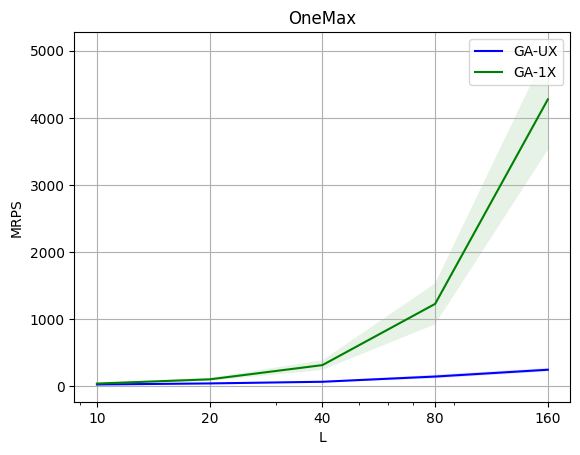

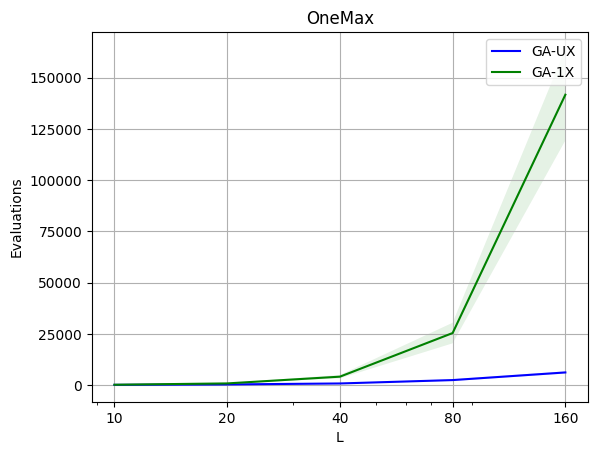

In [18]:
l_space_UX = l_space[:len(mean_mrps_values_onemax_UX)]
l_space_1X = l_space[:len(mean_mrps_values_onemax_1X)]
plotting(mean_mrps_values_onemax_UX, std_dev_mrps_values_onemax_UX, l_space_UX,  mean_mrps_values_onemax_1X, std_dev_mrps_values_onemax_1X,l_space_1X, "MRPS", "OneMax")
plotting(mean_evals_onemax_UX, std_evals_onemax_UX, l_space_UX, mean_evals_onemax_1X, std_evals_onemax_1X,l_space_1X, "Evaluations", "OneMax")

In [19]:
mean_mrps_values_leadingOnes_UX, std_dev_mrps_values_leadingOnes_UX, mean_evals_leadingOnes_UX, std_evals_leadingOnes_UX = experimental(crossover_UX, leadingOnes)
print(mean_mrps_values_leadingOnes_UX, std_dev_mrps_values_leadingOnes_UX, mean_evals_leadingOnes_UX, std_evals_leadingOnes_UX)

Exceeds
[  74.8  288.   972.8 3788.8] [ 11.6         78.05638987  98.31866557 570.13907075] [   324.88   2738.08  20675.84 164377.6 ] [   61.94030675   593.41411645  1940.41456354 23111.13215124]


In [20]:
mean_mrps_values_leadingOnes_1X, std_dev_mrps_values_leadingOnes_1X, mean_evals_leadingOnes_1X, std_evals_leadingOnds_1X = experimental(crossover_1X, leadingOnes)
print(mean_mrps_values_leadingOnes_1X, std_dev_mrps_values_leadingOnes_1X, mean_evals_leadingOnes_1X, std_evals_leadingOnds_1X)

Exceeds
[ 122.4  630.4 4172.8] [ 18.26033954 162.57133819 606.34722726] [   559.6    7032.32 109877.76] [  125.63630049  1494.27062395 13516.09913334]


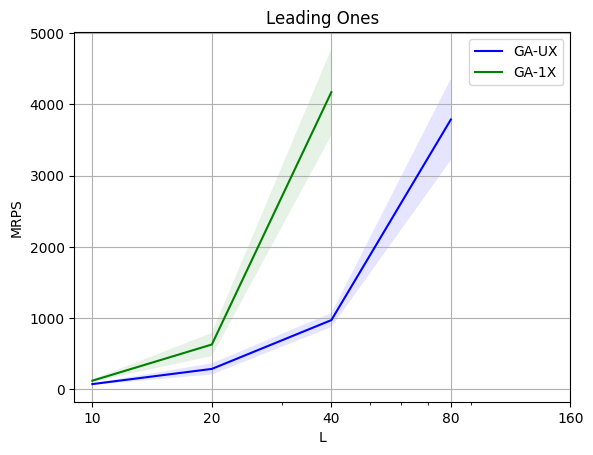

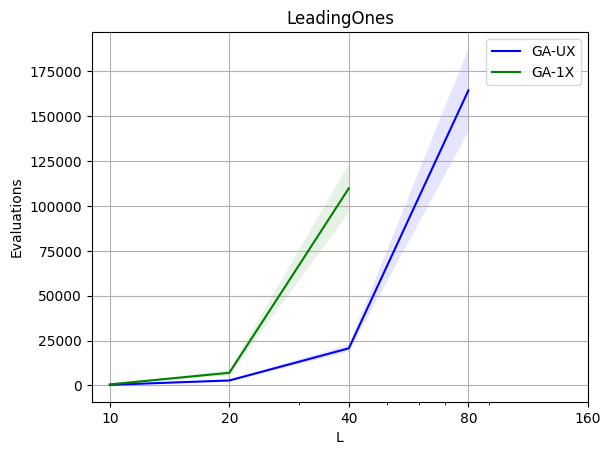

In [21]:
l_space_UX = l_space[:len(mean_mrps_values_leadingOnes_UX)]
l_space_1X = l_space[:len(mean_mrps_values_leadingOnes_1X)]
plotting(mean_mrps_values_leadingOnes_UX, std_dev_mrps_values_leadingOnes_UX, l_space_UX,  mean_mrps_values_leadingOnes_1X, std_dev_mrps_values_leadingOnes_1X, l_space_1X, "MRPS", "Leading Ones")
plotting(mean_evals_leadingOnes_UX, std_evals_leadingOnes_UX, l_space_UX,  mean_evals_leadingOnes_1X, std_evals_leadingOnds_1X, l_space_1X,  "Evaluations", "LeadingOnes")

In [22]:
mean_mrps_values_trap_UX, std_dev_mrps_values_trap_UX, mean_evals_trap_UX, std_evals_trap_UX = experimental(crossover_UX, concatenated_trap_K)
print(mean_mrps_values_trap_UX, std_dev_mrps_values_trap_UX, mean_evals_trap_UX, std_evals_trap_UX)

Exceeds
[ 422.4 4198.4] [127.03637274 597.08947403] [ 1137.28 47559.68] [ 359.53021792 7489.02874301]


In [23]:
mean_mrps_values_trap_1X, std_dev_mrps_values_trap_1X, mean_evals_trap_1X, std_evals_trap_1X = experimental(crossover_1X, concatenated_trap_K)
print(mean_mrps_values_trap_1X, std_dev_mrps_values_trap_1X, mean_evals_trap_1X, std_evals_trap_1X)

Exceeds
[ 122.4  416.  1196.8 4505.6] [ 29.07645095  85.86501034 246.29608198 992.8048348 ] [  432.8   3144.32 15396.48 96919.04] [   98.18643491   584.94249427  2703.21946604 17774.83954016]


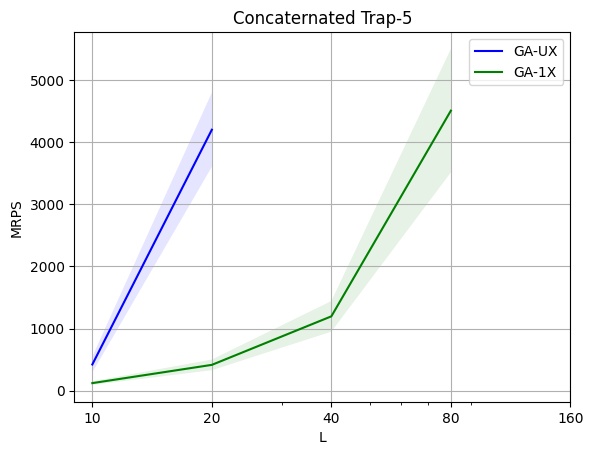

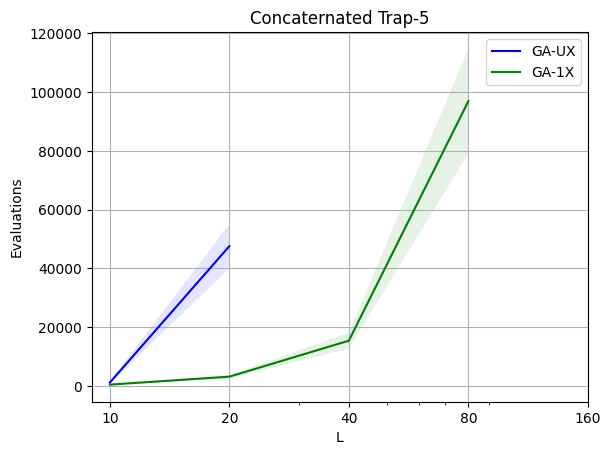

In [24]:
l_space_UX = l_space[:len(mean_mrps_values_trap_UX)]
l_space_1X = l_space[:len(mean_mrps_values_trap_1X)]
plotting(mean_mrps_values_trap_UX, std_dev_mrps_values_trap_UX, l_space_UX, mean_mrps_values_trap_1X, std_dev_mrps_values_trap_1X, l_space_1X, "MRPS", "Concaternated Trap-5")
plotting(mean_evals_trap_UX, std_evals_trap_UX, l_space_UX,  mean_evals_trap_1X, std_evals_trap_1X, l_space_1X,  "Evaluations", "Concaternated Trap-5")